## Working with a 3D large eddy simulation of shallow convection

### The simulation

* Objective: compare a single column of a GCM with large eddy simlations for three different cloud types (stratus, stratocumulus, trade cumulus)

[GCM paper](http://ezproxy.library.ubc.ca/login?url=http://doi.wiley.com/10.1002/jame.v5.4)

[LES paper](http://ezproxy.library.ubc.ca/login?url=http://doi.wiley.com/10.1002/jame.20025)

* We started with the trade cumulus simulation, then perturbed it by raising the temperature to 300 K and 301 K.

http://clouds.eos.ubc.ca/~phil/courses/atsc405/docs/cgils_ctl_s6_synthetic_albedo.mp4

http://clouds.eos.ubc.ca/~phil/courses/atsc405/docs/cgils_sst_300K_synthetic_albedo.mp4

http://clouds.eos.ubc.ca/~phil/courses/atsc405/docs/cgils_sst_301K_synthetic_albedo.mp4


###  The dataset  -- netccdf

[An example of reading a netCDF4 file ](http://schubert.atmos.colostate.edu/~cslocum/netcdf_example.html)


In [22]:
import glob
from netCDF4 import Dataset
from a405utils.ncdump import ncdump
from a405utils.download import download_file

download = False
if download:
    #
    #  satelite data for day 127 of 2014  Modis Aqua level 3 cloud data
    #
    url = 'http://clouds.eos.ubc.ca/~phil/Downloads/a405/ENT_CGILS_CTL_S6_3D_384x384x194_25m_1s_96_0000014160.nc'
    local_file = download_file(url)
    print('downloaded {}'.format(local_file))
    
the_file = glob.glob("*CTL*")[0]
with Dataset(the_file,'r') as ncin:
    ncdump(ncin)

NetCDF Global Attributes:
NetCDF dimension information:
	Name: x
		size: 384
		type: dtype('float32')
		units: 'm'
	Name: y
		size: 384
		type: dtype('float32')
		units: 'm'
	Name: z
		size: 194
		type: dtype('float32')
		units: 'm'
		long_name: 'height'
	Name: time
		size: 1
		type: dtype('float32')
		units: 'd'
		long_name: 'time'
NetCDF variable information:
	Name: p
		dimensions: ('z',)
		size: 194
		type: dtype('float32')
		units: 'mb'
		long_name: 'pressure'
	Name: U
		dimensions: ('time', 'z', 'y', 'x')
		size: 28606464
		type: dtype('float32')
		long_name: 'X Wind Component                                                                '
		units: 'm/s       '
	Name: V
		dimensions: ('time', 'z', 'y', 'x')
		size: 28606464
		type: dtype('float32')
		long_name: 'Y Wind Component                                                                '
		units: 'm/s       '
	Name: W
		dimensions: ('time', 'z', 'y', 'x')
		size: 28606464
		type: dtype('float32')
		long_name: 'Z Wind Compone

### liquid water cross section at 1 km



In [23]:
def get_var(the_file,varname):
    with Dataset(the_file,'r') as ncin:
         out=ncin.variables[varname][...]
         x = ncin.variables['x'][...]
         y = ncin.variables['y'][...]
         z = ncin.variables['z'][...]
         out = out.squeeze()  #remove the time dimension, since we only have one timestep
    return x,y,z,out
x,y,z,qn = get_var(the_file, 'QN')
print(the_file)
print(qn.max())

ENT_CGILS_CTL_S6_3D_384x384x194_25m_1s_96_0000014160.nc
3.03553


In [24]:
#
#  find the index for z = 1000 meters
#

level = np.searchsorted(z, 1000)
print(level)

40


In [25]:
%matplotlib inline

# get the cloud liquid water at 1000 m
#
horiz_cross_sec = qn[level,:,:]
#
# find the cross section cloud fraction
#
cloud_frac=np.sum(horiz_cross_sec > 0)/horiz_cross_sec.size
print('cloud fraction: {:5.3f}'.format(cloud_frac))

cloud fraction: 0.050


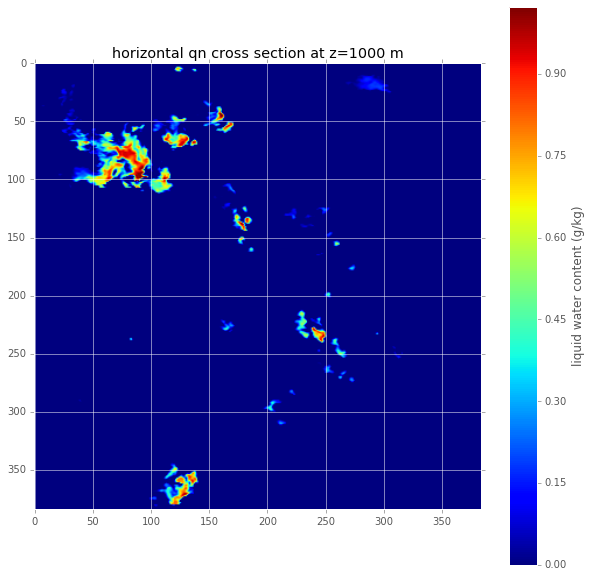

In [26]:
%matplotlib inline
plt.style.use('ggplot')
from matplotlib import pyplot as plt
plt.close('all')
fig,ax =plt.subplots(1,1,figsize=(10,10))
whole_scene=ax.imshow(horiz_cross_sec)
cax=plt.colorbar(whole_scene,ax=ax)
cax.set_label('liquid water content (g/kg)')
title = 'horizontal qn cross section at z=1000 m'
ax.set_title(title)

### zoom in on  the top left corner

Switch from [imshow](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow) to 
[pcolormesh](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.pcolormesh) so we can orient the axes along model x,y, and z coordinates.  Note that if y is north/south (north up), then imshow plots the image upside down.

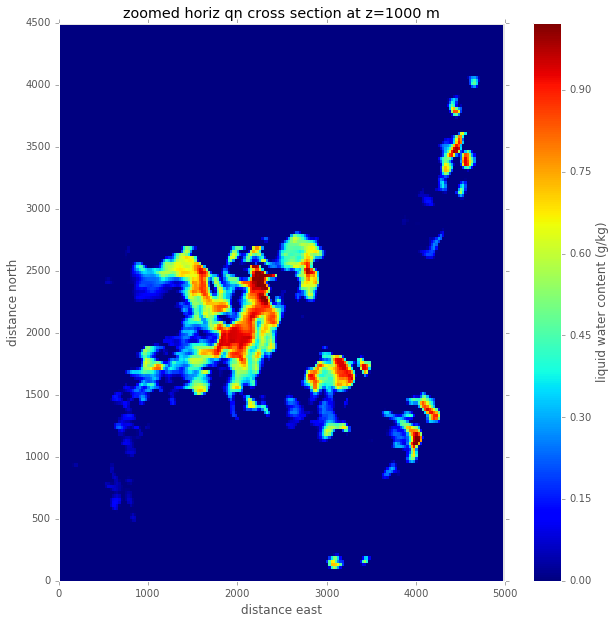

In [27]:
#
# it helps in checking your orientation to make the selection
# have different numbers of rows and columns
#
end_col = 200
end_row = 180
fig,ax =plt.subplots(1,1,figsize=(10,10))
image=ax.pcolormesh(x[:end_col],y[:end_row],horiz_cross_sec[:end_row,:end_col])
ax.set(xlabel='distance east',ylabel='distance north')
cax = plt.colorbar(image,ax=ax)
cax.set_label('liquid water content (g/kg)')
ax.set_title('zoomed horiz qn cross section at z=1000 m')

### Get a vertical cross section along y = 2km

In [28]:
row_number = np.searchsorted(y,2000)  #(y index of 80)

In [29]:
row_number

80

(194, 200)
194 200


[<matplotlib.text.Text at 0x15e453a20>, <matplotlib.text.Text at 0x15e452470>]

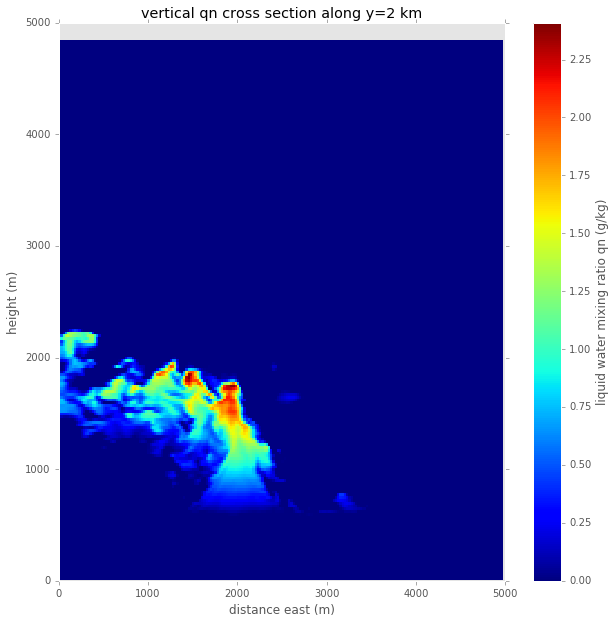

In [30]:
vert_cross_sec = qn[:,row_number,:end_col]
print(vert_cross_sec.shape)
print(len(z),len(x[:end_col]))
fig,ax = plt.subplots(1,1,figsize=(10,10))
image=ax.pcolormesh(x[:end_col],z,vert_cross_sec[:,:end_col])
cax = plt.colorbar(image,ax=ax)
cax.set_label('liquid water mixing ratio qn (g/kg)')
ax.set_title('vertical qn cross section along y=2 km')
ax.set(xlabel='distance east (m)',ylabel='height (m)')

### Find the vapor mixing ratio along this cross section

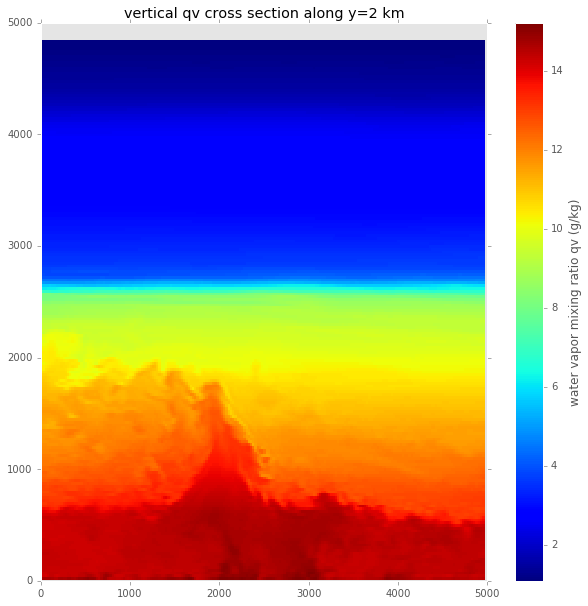

In [31]:
plt.close('all')
x,y,z,qv = get_var(the_file, 'QV')
vert_cross_sec = qv[:,row_number,:end_col]
fig,ax = plt.subplots(1,1,figsize=(10,10))
image=ax.pcolormesh(x[:end_col],z,vert_cross_sec[:,:end_col])
cax = plt.colorbar(image,ax=ax)
cax.set_label('water vapor mixing ratio qv (g/kg)')
ax.set_title('vertical qv cross section along y=2 km')

### For Monday

1\.  Read Thompkins chapter 4 parameterization notes through section 4.7.1

2\.  Read [Zhu and Randall, 1996](http://kiwi.atmos.colostate.edu/pubs/XuandRandall-semiempirical-1996.pdf)

3\.  Hand in a notebook that adds cells to cgilsI.ipynb to:

     * use pcolormesh to plot a vertical cross section of the relative humidity for along y=2 km, x= 0-5 km
     
     * use plot to plot a vertical profile of the horizontal mean RH in for this cross section as a function of height
     
     * use plot to plot a vertical profile of the horizontal standard deviation of RH as a function of height

### Calculate the relative humidity from qv and rsat

Use newaxis to make the shapes work for [numpy broadcasting](http://www.scipy-lectures.org/intro/numpy/operations.html#broadcasting)

esat is 3D:  (194, 384, 384)
press is 1D:  (194,)


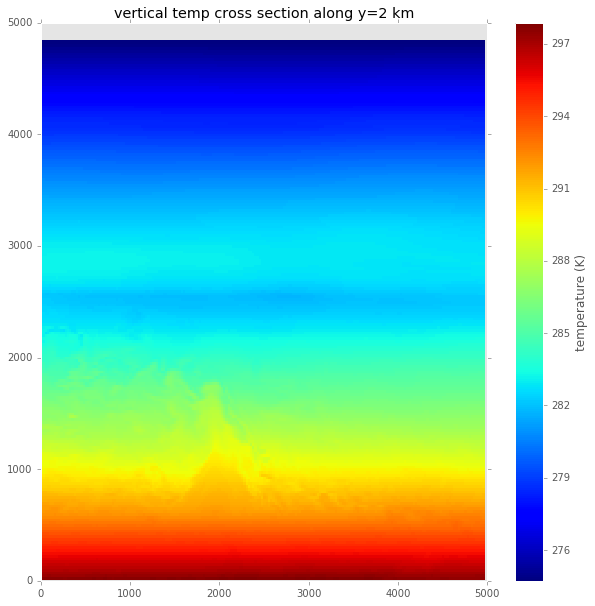

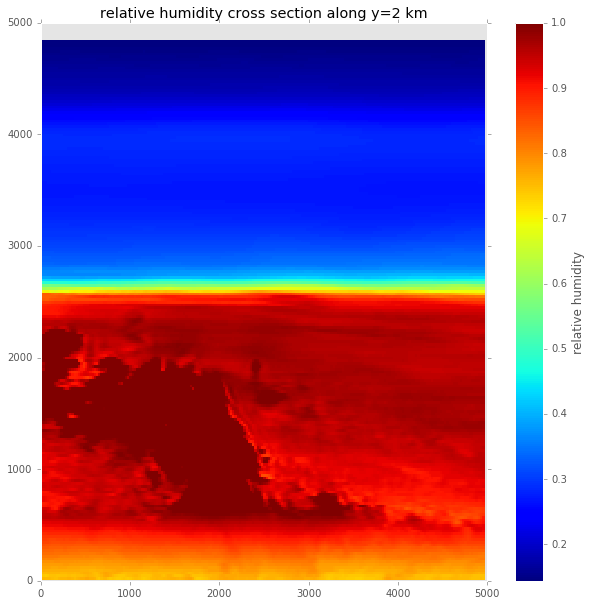

In [32]:
from a405thermo.thermlib import find_rsat, find_esat
from a405thermo.constants import constants as c
x,y,z,temp = get_var(the_file,'TABS')
x,y,z,press = get_var(the_file,'p')
vert_cross_sec = temp[:,row_number,:end_col]
plt.close('all')
fig,ax = plt.subplots(1,1,figsize=(10,10))
image=ax.pcolormesh(x[:end_col],z,vert_cross_sec[:,:end_col])
cax = plt.colorbar(image,ax=ax)
cax.set_label('temperature (K)')
ax.set_title('vertical temp cross section along y=2 km')

esat = find_esat(temp)
print('esat is 3D: ',esat.shape)
print('press is 1D: ',press.shape)
#
# add dimensions to the 1D pressure vectory so
# that it can be used in the denominator 
#
press = press[:,np.newaxis,np.newaxis]*100.  #convert to Pa, make pressure 3D
rsat = c.eps*esat/(press - esat)*1.e3  #convert to g/kg, rsat has dimensions of esat
rh = qv/rsat

fig,ax = plt.subplots(1,1,figsize=(10,10))
vert_cross_sec = rh[:,row_number,:end_col]
image=ax.pcolormesh(x[:end_col],z,vert_cross_sec[:,:end_col])
cax = plt.colorbar(image,ax=ax)
cax.set_label('relative humidity')
ax.set_title('relative humidity cross section along y=2 km')

### screen out cells with RH > 1 using a smaked array

Also, contract the range of the colormap so that all the 256 colors
are spread between RH 0.8 to 0.98

[(0, 2500)]

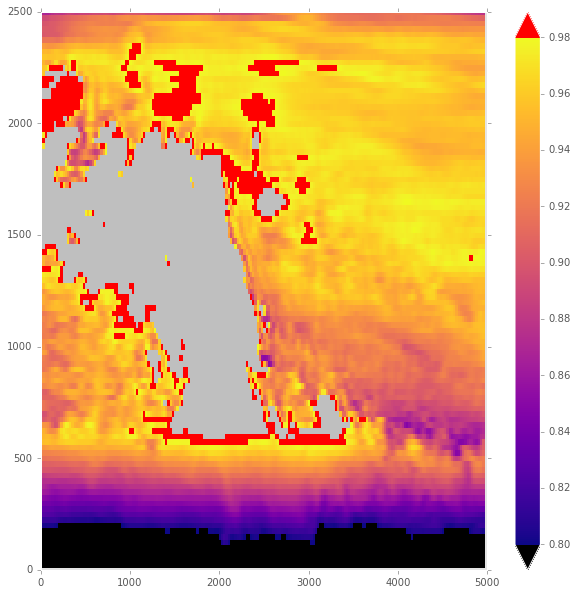

In [33]:
from matplotlib.colors import Normalize
fig,ax=plt.subplots(1,1,figsize=(10,10))
pal = plt.get_cmap('plasma')
pal.set_bad('0.75') #75% grey
pal.set_over('r')  #color cells > 0.98 red
pal.set_under('k')  #color cells < 0.75 black
vmin= 0.8
vmax= 0.98
#
#mask relative humidities > 1
#using a masked array
#
import numpy.ma as ma
mask = vert_cross_sec > 1
ma_rh_vert = ma.array(vert_cross_sec, mask = mask)
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)
image=ax.pcolormesh(x[:end_col],z,ma_rh_vert[:,:end_col],cmap=pal,norm=the_norm)
cax=plt.colorbar(image,ax = ax,extend='both')
ax.set(ylim=[0,2500])



    



### find the mean and variance for the subset

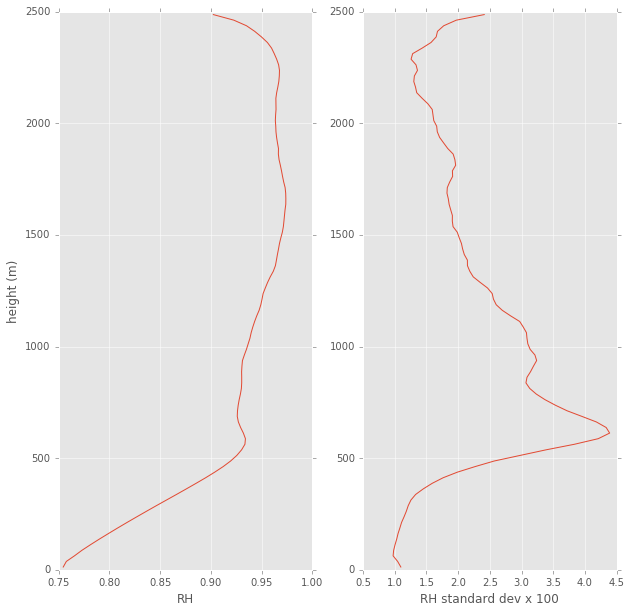

In [34]:
end_z = np.searchsorted(z,2500.)
rh_subset = rh[:end_z,:end_row,:end_col]
mean_rh_xy = rh_subset.mean(axis=(1,2))
sd_rh_xy = rh_subset.var(axis=(1,2))**0.5
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,10))
ax1.plot(mean_rh_xy,z[:end_z])
ax2.plot(sd_rh_xy*100.,z[:end_z])
ax1.set(ylabel='height (m)',xlabel='RH')
out=ax2.set(xlabel='RH standard dev x 100')

### RH histogram outside of cloud

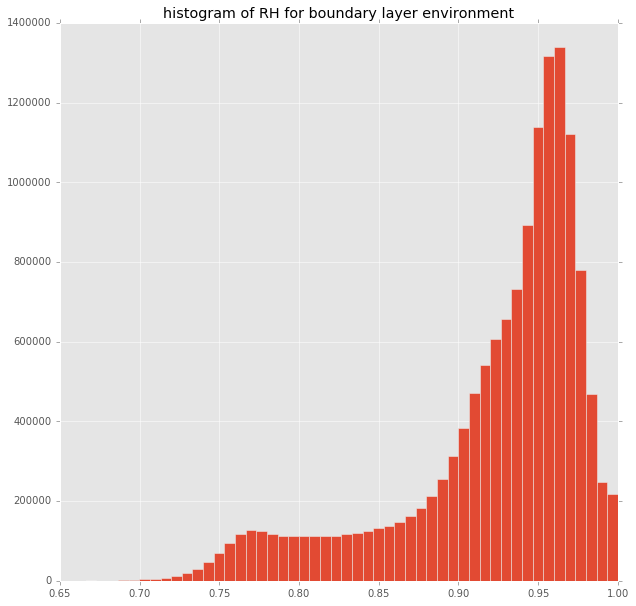

In [35]:
rh_boundary = rh[:end_z,:,:]
rh_environ = rh_boundary[rh_boundary < 1.]
fig,ax = plt.subplots(1,1,figsize=(10,10))
out=ax.hist(rh_environ.flatten(),bins=50)
ax.set_title('histogram of RH for boundary layer environment')